In [1]:
import mne
from mne.preprocessing import (ICA)
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import mat73

# Load data

In [2]:
def load_session(path, sampling_freq, eeg_ch_names):
    # load raw numpy data
    mat = mat73.loadmat(path)
    mat = mat['y']

    # build metadata structure
    ch_names = eeg_ch_names + ['stim1'] 
    ch_types = (['eeg'] * 8) + ['stim']
    info = mne.create_info(ch_names, sfreq=sampling_freq, ch_types=ch_types)

    mat[1:9] = mat[1:9] * 1E-6 # mne expect raw data in Volt, loaded data is in micro volts!
    raw = mne.io.RawArray(mat[1:10], info) # index 1-10 only for EEG and stim channels

    return raw

Creating RawArray with float64 data, n_channels=9, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


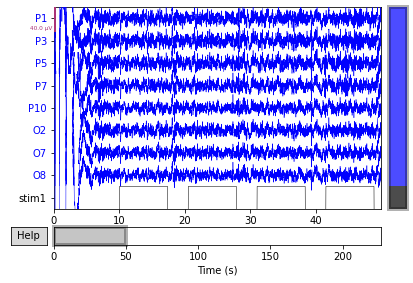

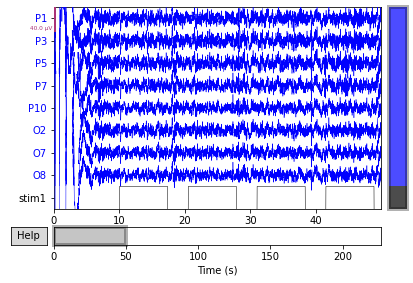

In [3]:
fs = 256
CH_NAMES = ['P1','P3','P5','P7','P10','O2','O7','O8']
subj1_session1 = Path('new_data\subject_1_fvep_led_training_2.mat')

raw = load_session(subj1_session1, fs, CH_NAMES)

raw.plot(duration=50, color={'eeg':'blue'})

40 events found
Event IDs: [0 1]


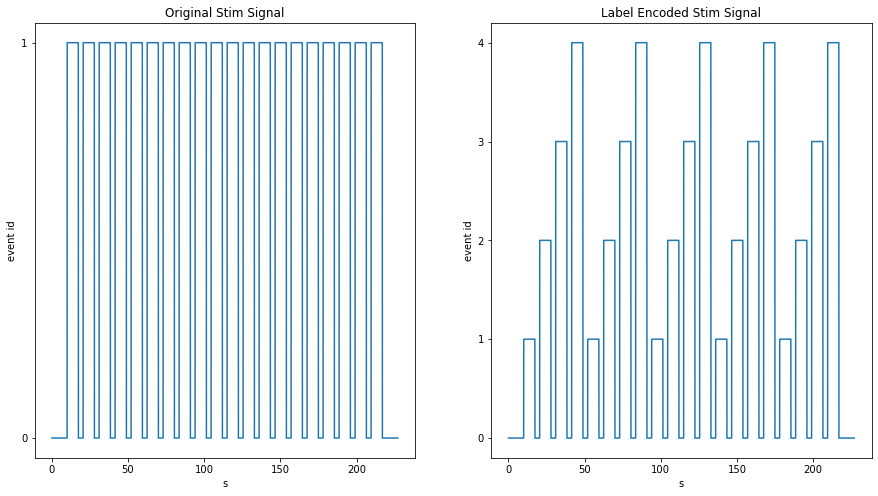

In [4]:
def add_labels_to_stim(raw, n_trials=4):
    events = mne.find_events(raw, stim_channel='stim1', output='step')

    on_set_mask = events[:,2] == 1 # stim channel goes from 0 to 1
    on_set_events = events[on_set_mask, 0]

    off_set_mask = events[:,2] == 0  # stim channel goes from 1 to 0
    off_set_events = events[off_set_mask,0]

    raw_copy = raw.copy() # do not effect the original raw signal
    data = raw_copy._data # directly access the underlying numpy data!

    # loop trough events and encode the label as a stim channel event_id
    for i, (on_set, off_set) in enumerate(zip(on_set_events, off_set_events)):
        trial_label = (i % n_trials) +1 # just a trick to avoid looping i in range(1,5)
        data[8, on_set:off_set] = trial_label # modify the stim channel (index 8)

    return raw_copy

raw2 = add_labels_to_stim(raw)

orig_stim, times = raw[8]
modified_stim, times = raw2[8]


fig, axes = plt.subplots(ncols=2, figsize=(15,8))

axes[0].plot(times, orig_stim[0])
axes[0].set_title('Original Stim Signal')
axes[1].plot(times, modified_stim[0])
axes[1].set_title('Label Encoded Stim Signal')

for ax in axes:
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    ax.set_xlabel('s')
    ax.set_ylabel('event id')

In [5]:
data = raw2.get_data()
np.save(file='data_raw.npy', arr=data)

raw2.save("data_raw.fif", overwrite=True)

Overwriting existing file.
Writing C:\Users\huawei\My_notebook\SSVEP\data_raw.fif
Closing C:\Users\huawei\My_notebook\SSVEP\data_raw.fif
[done]


Opening raw data file data_raw.fif...
Isotrak not found
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.
Reading 0 ... 58111  =      0.000 ...   226.996 secs...


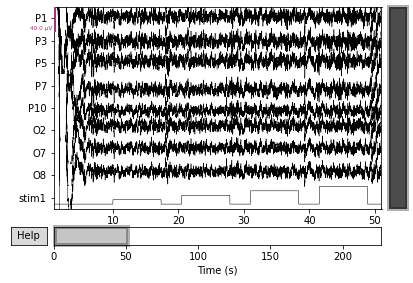

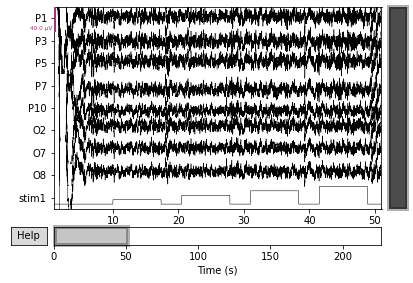

In [6]:
raw = mne.io.read_raw_fif("data_raw.fif", preload = True)
raw.plot(start=1, duration=50)

In [7]:
raw.get_data().shape

(9, 58112)

In [8]:
raw_label = raw.copy()

In [9]:
label=raw_label.get_data()[8,:]

In [10]:
label.shape

(58112,)

In [11]:
hf=None

# Raw

In [12]:
import numpy as np

In [13]:
raw_eeg = raw.pick_types(eeg=True)
raw_eeg

<Raw | data_raw.fif, 8 x 58112 (227.0 s), ~3.6 MB, data loaded>

In [14]:
np_raw=np.vstack([raw_eeg.get_data(), label])

# Filt 40 Hz

In [15]:
filt=raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



# Filt + ICA

In [16]:
filt_eeg=raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


<ipython-input-17-fa5f295f6cd8>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=8)


Fitting ICA took 0.5s.
Creating RawArray with float64 data, n_channels=8, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


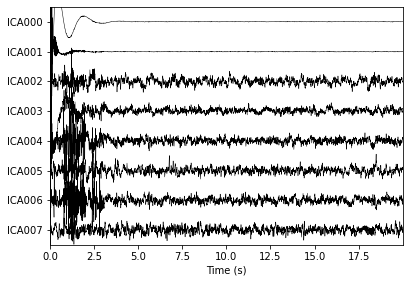

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


<Raw | data_raw.fif, 8 x 58112 (227.0 s), ~3.6 MB, data loaded>

In [17]:
ica = ICA(n_components=8)
ica.fit(filt_eeg)
filt_eeg.load_data()
ica.plot_sources(filt_eeg, show_scrollbars=False)
ica.exclude = [0, 1]  # indices chosen based on various plots above
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_eeg.copy()
ica.apply(reconst_raw)

In [18]:
filt_ICA = reconst_raw.copy()

In [19]:
np_filt_ICA = np.vstack([filt_ICA.get_data(), label])

# Filt + CAR

In [20]:
filt_eeg=raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



In [21]:
avg_ref = filt_eeg.copy().set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [22]:
filt_CAR = avg_ref.copy()

In [23]:
np_filt_CAR = np.vstack([filt_CAR.get_data(), label])

# Filt + ICA + CAR

In [24]:
filt_eeg = raw_eeg.filter(l_freq=1,h_freq=hf)

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 sec)



Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


<ipython-input-25-fa5f295f6cd8>:1: DeprecationWarning: Version 0.23 introduced max_iter="auto", setting max_iter=1000 for `fastica` and max_iter=500 for `infomax` and `picard`. The current default of max_iter=200 will be changed to "auto" in version 0.24.
  ica = ICA(n_components=8)


Fitting ICA took 0.3s.
Creating RawArray with float64 data, n_channels=8, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


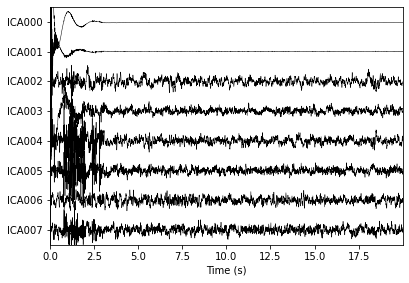

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 2 ICA components
    Projecting back using 8 PCA components


<Raw | data_raw.fif, 8 x 58112 (227.0 s), ~3.6 MB, data loaded>

In [25]:
ica = ICA(n_components=8)
ica.fit(filt_eeg)
filt_eeg.load_data()
ica.plot_sources(filt_eeg, show_scrollbars=False)
ica.exclude = [0, 1]  # indices chosen based on various plots above
# ica.apply() changes the Raw object in-place, so let's make a copy first:
reconst_raw = filt_eeg.copy()
ica.apply(reconst_raw)

In [26]:
avg_ref = reconst_raw.copy().set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom EEG reference.


In [27]:
filt_ica_car = avg_ref.copy()

In [28]:
np_filt_ica_car = np.vstack([filt_ica_car.get_data(), label])

In [29]:
np_filt_ica_car.shape

(9, 58112)

In [30]:
np.save(file='Risultati/np_raw2', arr=np_raw)
np.save(file='Risultati/np_filt_ICA2', arr=np_filt_ICA)
np.save(file='Risultati/np_filt_CAR2', arr=np_filt_CAR)
np.save(file='Risultati/np_filt_ica_car2', arr=np_filt_ica_car)

In [31]:
"""np.save(file='Risultati/np_hf40_raw2', arr=np_raw)
np.save(file='Risultati/np_hf40_ICA2', arr=np_filt_ICA)
np.save(file='Risultati/np_hf40_CAR2', arr=np_filt_CAR)
np.save(file='Risultati/np_hf40_ica_car2', arr=np_filt_ica_car)"""

"np.save(file='Risultati/np_hf40_raw2', arr=np_raw)\nnp.save(file='Risultati/np_hf40_ICA2', arr=np_filt_ICA)\nnp.save(file='Risultati/np_hf40_CAR2', arr=np_filt_CAR)\nnp.save(file='Risultati/np_hf40_ica_car2', arr=np_filt_ica_car)"

# Riconverto in .fif

In [32]:
fs = 256
ch_names = ['P1','P3','P5','P7','P10','O2','O7','O8','stim']
ch_types = (['eeg'] * 8) + ['stim']

info = mne.create_info(ch_names, sfreq=fs, ch_types=ch_types)
data = mne.io.RawArray(np_raw, info) # index 1-10 only for EEG and stim channels

Creating RawArray with float64 data, n_channels=9, n_times=58112
    Range : 0 ... 58111 =      0.000 ...   226.996 secs
Ready.


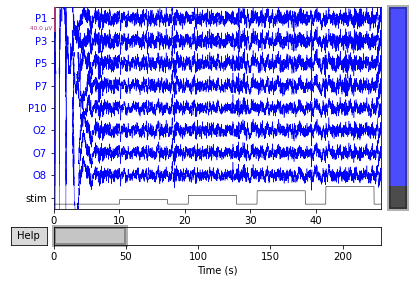

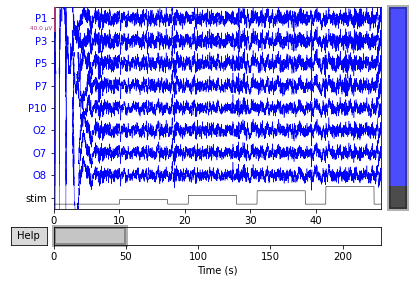

In [33]:
data.plot(duration=50, color={'eeg':'blue'})

In [34]:
np.unique(data.get_data()[8])

array([0., 1., 2., 3., 4.])

# PSD

In [35]:
# Construct epochs
event_id = {'9Hz': 1, '10Hz': 2, '12Hz': 3, '15Hz': 4}
events = mne.find_events(data, stim_channel='stim')
baseline = None

tmin= 0
tmax = 7.35  # in s

epochs = mne.Epochs(
        data, events=events,
        event_id=event_id, tmin=tmin,
        tmax=tmax, baseline=baseline, verbose=True)

20 events found
Event IDs: [1 2 3 4]
Not setting metadata
Not setting metadata
20 matching events found
No baseline correction applied
0 projection items activated


In [36]:
type(epochs)

mne.epochs.Epochs

In [37]:
data9 = epochs['9Hz']
data10 = epochs['10Hz']
data12 = epochs['12Hz']
data15 = epochs['15Hz']

Loading data for 5 events and 1883 original time points ...
    Using multitaper spectrum estimation with 7 DPSS windows


<ipython-input-44-0e836fce5f55>:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  data12.plot_psd(fmin = 3, fmax = 32)


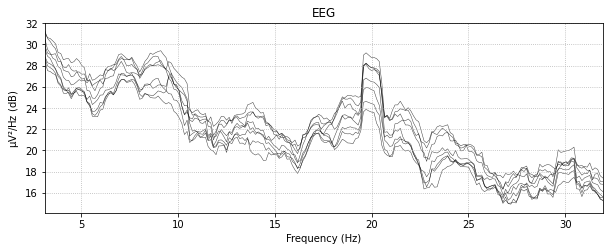

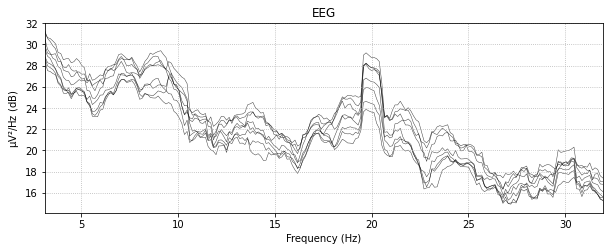

In [44]:
data12.plot_psd(fmin = 3, fmax = 32)